## **K-Nearest Neighbors (K-NN)**


In [543]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [544]:
sns.set(style="darkgrid")

### **Data Loading and Inspection**


In [545]:
data = pd.read_csv("Social_Network_Ads.csv")

In [546]:
data.sample(5, random_state=42)

,Age,EstimatedSalary,Purchased
209,46,22000,0
280,59,88000,1
33,28,44000,0
210,48,96000,1
93,29,28000,0


In [547]:
data.shape

(400, 3)

In [548]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype
---  ------           --------------  -----
 0   Age              400 non-null    int64
 1   EstimatedSalary  400 non-null    int64
 2   Purchased        400 non-null    int64
dtypes: int64(3)
memory usage: 9.5 KB


In [549]:
data.isnull().sum()

Age                0
EstimatedSalary    0
Purchased          0
dtype: int64

In [550]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Age,400.0,37.6550,10.482877,18.0,29.75,37.0,46.0,60.0
EstimatedSalary,400.0,69742.5000,34096.960282,15000.0,43000.00,70000.0,88000.0,150000.0
Purchased,400.0,0.3575,0.479864,0.0,0.00,0.0,1.0,1.0


### **Exploratory Data Analysis (EDA)**


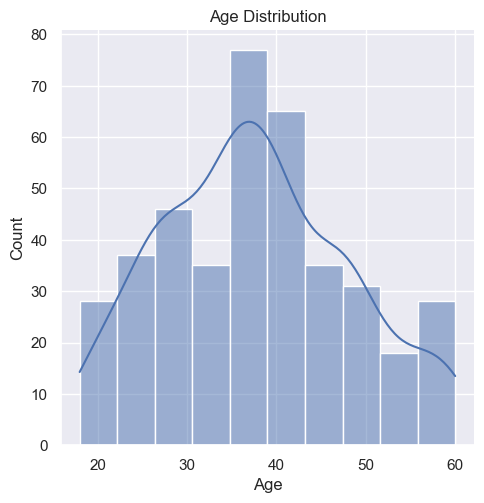

In [551]:
sns.displot(data=data, x="Age", kde=True, bins=10)
plt.title("Age Distribution")
plt.show()

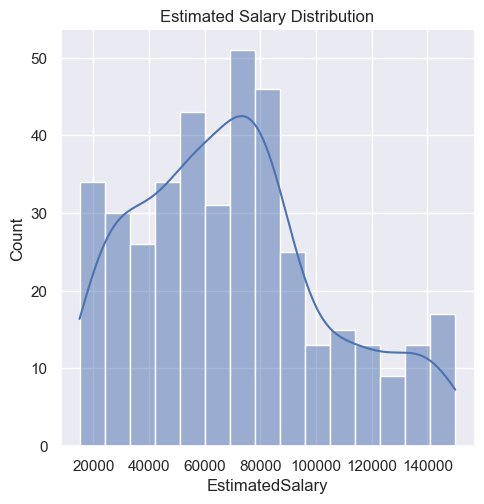

In [552]:
sns.displot(data=data, x="EstimatedSalary", kde=True, bins=15)
plt.title("Estimated Salary Distribution")
plt.show()

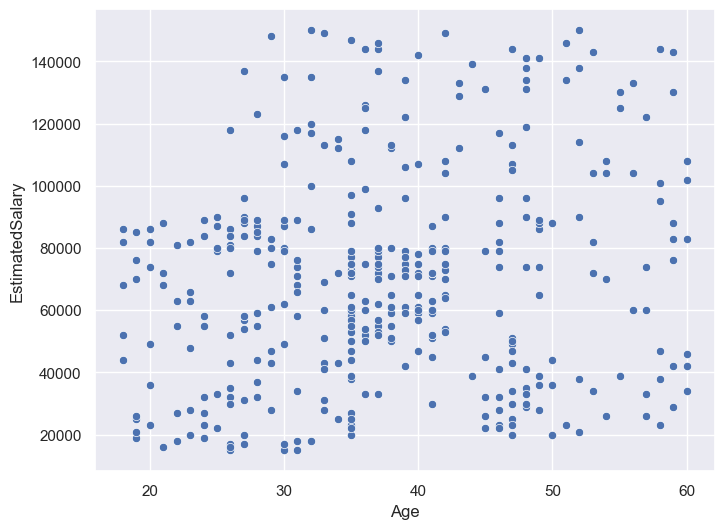

In [553]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x="Age", y="EstimatedSalary")
plt.show()

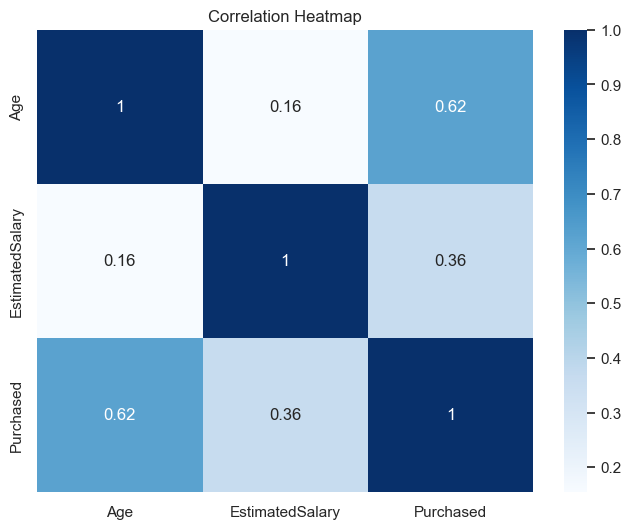

In [554]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(data.corr(), annot=True, cmap="Blues")
plt.title("Correlation Heatmap")
plt.show()

### **Data Preparation**


**Split the dataset into features and target variable**

In [555]:
X = data.drop("Purchased", axis=1)
y = data[["Purchased"]]

**Split the data into training and testing sets**

In [556]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X.values,
    y.values,
    test_size=0.33,
    random_state=42,
    stratify=y,
)

In [557]:
y.shape, y_train.shape, y_test.shape

((400, 1), (268, 1), (132, 1))

### **Feature Scaling**


In [558]:
from sklearn.preprocessing import StandardScaler

In [559]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

### **Training a K-Nearest Neighbors (K-NN) Classifier with RandomizedSearchCV**


In [560]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier

In [561]:
KNeighborsClassifier().get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

In [562]:
classifier = KNeighborsClassifier()

param_dist = {
    "n_neighbors": np.arange(3, 50, 2),
    "weights": ["uniform", "distance"],
    "p": [1, 2],
}

In [563]:
random_search = RandomizedSearchCV(
    estimator=classifier,
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    random_state=42,
    scoring="f1",
    verbose=1,
)

random_search.fit(X_train, y_train.ravel())

Fitting 5 folds for each of 50 candidates, totalling 250 fits


C:\Users\cw\AppData\Roaming\Python\Python312\site-packages\numpy\ma\core.py:2846: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


RandomizedSearchCV(cv=5, estimator=KNeighborsClassifier(), n_iter=50, n_jobs=-1,
                   param_distributions={'n_neighbors': array([ 3,  5,  7,  9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35,
       37, 39, 41, 43, 45, 47, 49]),
                                        'p': [1, 2],
                                        'weights': ['uniform', 'distance']},
                   random_state=42, scoring='f1', verbose=1)

**Fit the best model on the training data**


In [564]:
best_model = random_search.best_estimator_
best_model.fit(X_train, y_train.ravel())

KNeighborsClassifier(n_neighbors=np.int64(7))

### **Making Predictions And Evaluating The Model**


In [565]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

In [566]:
# Predictions on training data
y_train_pred = best_model.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.9253731343283582

In [567]:
# Predictions on testing data
y_test_pred = best_model.predict(X_test)
accuracy_score(y_test, y_test_pred)

0.9318181818181818

### **Confusion Matrix**


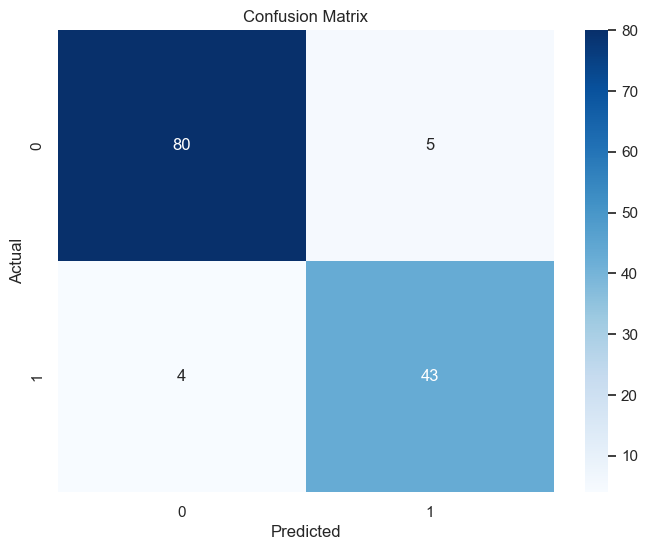

In [568]:
conf_matrix = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [569]:
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.95      0.94      0.95        85
           1       0.90      0.91      0.91        47

    accuracy                           0.93       132
   macro avg       0.92      0.93      0.93       132
weighted avg       0.93      0.93      0.93       132



### **Plot decision boundaries for the training and testing data**


In [570]:
def plot_decision_boundary(X, y, model):
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    h = 0.02
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.3, cmap="viridis")
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors="k", marker="o", cmap="viridis")
    plt.xlabel("Age (scaled)")
    plt.ylabel("Estimated Salary (scaled)")
    plt.title("Decision Boundary")
    plt.show()

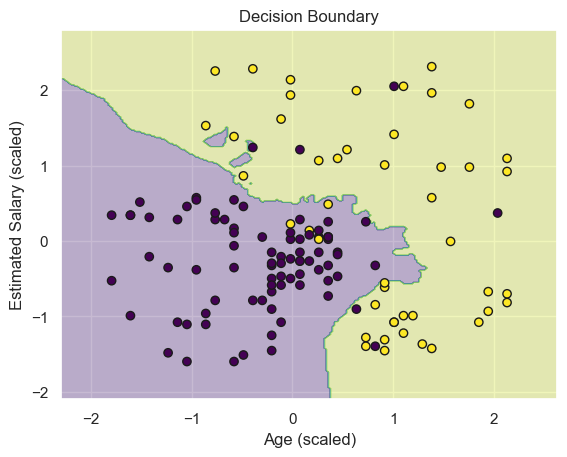

In [571]:
plot_decision_boundary(X_test, y_test, best_model)

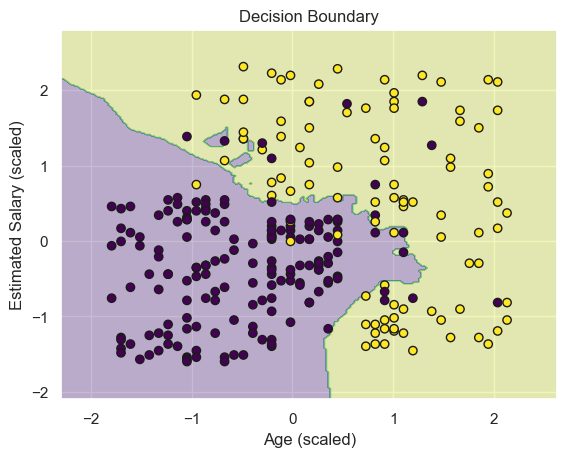

In [572]:
plot_decision_boundary(X_train, y_train, best_model)

### **Popular Distance Metrics K-NN**


##### 1. **Euclidean Distance**

- **Formula**: $d(p, q) = \sqrt{\sum_{i=1}^n (p_i - q_i)^2}$
- **Description**: This is the most common distance metric. It calculates the straight-line distance between two points in Euclidean space. It works well with continuous numerical data.
- **Use Case**: Best used when the data has similar scales and is dense.

##### 2. **Manhattan Distance (L1 Distance)**

- **Formula**: $d(p, q) = \sum_{i=1}^n |p_i - q_i|$
- **Description**: Also known as City Block or L1 distance, it measures the distance between two points by summing the absolute differences of their coordinates. This metric is more robust to outliers compared to Euclidean distance.
- **Use Case**: Useful for grid-like data or when movements are restricted to orthogonal directions, like in certain games or scenarios where movement is along axes.

##### 3. **Minkowski Distance**

- **Formula**: $d(p, q) = \left( \sum_{i=1}^n |p_i - q_i|^p \right)^{1/p}$
- **Description**: A generalized form of both Euclidean and Manhattan distances. The parameter $p$ determines the type of distance:
  - $p = 1$: Manhattan distance
  - $p = 2$: Euclidean distance
- **Use Case**: Allows flexibility by adjusting the value of $p$. For example, choosing $p > 2$ gives more weight to large differences.
